In [1]:
from __future__ import print_function, division, absolute_import
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rc
from scipy.signal import spectrogram

from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.constants import speed_of_light

#plt.style.use('dark_background')
rc('font', size=15)
rc('legend', fontsize=10)
rc('xtick', labelsize=12)

fig_size = (12, 5)

In [3]:
from skreflectometry.mode_O import N2O, refractive_matrix_O, cutoff_freq_O, abel_inversion, CalcInvPerfO
from skreflectometry.mode_X import refraction_index_X, refractive_matrix_X, cutoff_freq_X
from skreflectometry.physics import cyclotron_frequency, plasma_frequency, cyclotron_field, plasma_density, upper_hybrid_frequency, distance_vacuum
#from SimulateGroupDelayDispersive import create_density, create_ne_drop
from skreflectometry.data_generation import density_profile, density_add_bump, magnetic_field_profile
from skreflectometry.reflectometry_sim import phase_delay2, group_delay, beat_signal, beat_maximums, phase_delay
from skreflectometry.graphs import (
    plot_refractive_matrix, plot_beat_spectogram, plot_profiles_reconstruction
)

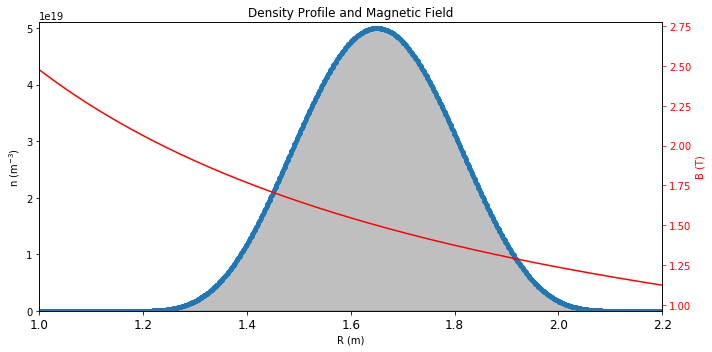

In [4]:
plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
radius_arr, dens_prof = density_profile(n_points=1000)
#dens_prof = density_add_bump(radius_arr, dens_prof, bump_pos=1.5, bump_size=0.2, bump_height=0.5)
# plt.plot(radius_arr, dens_prof, '-o', lw=2)
# plt.fill_between(radius_arr, dens_prof, 0.0, color='k', alpha=0.25)

# plt.xlabel('R (m)')
# plt.ylabel('n (m$^{-3}$)')
# plt.title('Density Profile for O-Mode')

# plt.xlim(1.0, 2.2)
# plt.ylim(0, 5.1e19)

###

# ax1 = plt.subplot(1, 2, 2)
ax1 = plt.gca()
#rs, ns = density_profile(radius_arr=np.linspace(2.15, 2.1, 600), m=30, n=3, dens_central=10e19, r_vacuum=0.002)
rs, ns = density_profile(n_points=1000)
bs = magnetic_field_profile(rs, mag_field_ref=1.5, pos_ref=1.65)
#rs = rs[0] - rs
#ns = density_add_bump(rs, ns, bump_pos=0.02, bump_size=0.001, bump_height=.95*.95)
plt.plot(rs, ns, '-o', markersize=4)
plt.fill_between(rs, ns, 0.0, color='k', alpha=0.25)

plt.xlabel('R (m)')
plt.ylabel('n (m$^{-3}$)')
plt.title('Density Profile and Magnetic Field')

#plt.xlim(0, 0.05)
plt.xlim(1.0, 2.2)
plt.ylim(0, 5.1e19)

ax2 = ax1.twinx()
ax2.plot(rs, bs, 'r-')
ax2.set_ylabel('B (T)', color='r')
ax2.tick_params('y', colors='r')

plt.tight_layout()
#plt.savefig('images/density_profiles.png', dpi=200)
plt.show()

In [62]:
f_sampling = 40.99e6
sweep_time = 25e-6
n_points_fs = int(sweep_time * f_sampling)

fs_O_limits = np.array([16e9, 50e9])
sweep_rate = np.abs(np.diff(fs_O_limits)) / sweep_time

f_sampling_X = 40.99e6
sweep_time = 25e-6
n_points_fs_X = int(sweep_time * f_sampling_X)
# fs_X_limits = np.array([40e9, 100e9])
fs_X_limits = np.array([40e9, 60e9])
sweep_rate_X = np.abs(np.diff(fs_X_limits)) / sweep_time

### Calcs ###

#fs_O = np.sort(np.hstack([np.logspace(0, 11, 500), np.linspace(1, 1e11, 500)]))
#Probing frequencies
fs_O = np.linspace(fs_O_limits[0], fs_O_limits[1], n_points_fs)
fs_X = np.linspace(fs_X_limits[0], fs_X_limits[1], n_points_fs_X)
#fs_X = np.linspace(40e9, 100e9, 500)

#n_index_O = refractive_matrix_O(dens_prof, fs_O)
n_index_X = refractive_matrix_X(ns, fs_X, mag_field=bs, squared=False)

n_index_O_sq = refractive_matrix_O(dens_prof, fs_O)
n_index_X_sq = refractive_matrix_X(ns, fs_X, mag_field=bs, squared=True)

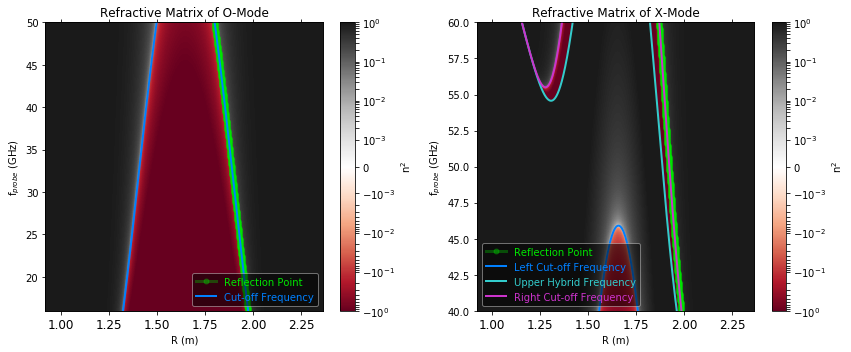

In [63]:
plt.figure(figsize=fig_size)

ax_O = plt.subplot(1, 2, 1)
    
plot_refractive_matrix(radius_arr, dens_prof, fs_O, n_index_O_sq, axis=ax_O, wave_mode='O',
                       antenna_side='lfs', legend_loc='lower right', title='O-Mode')

ax_X = plt.subplot(1, 2, 2)
    
plot_refractive_matrix(radius_arr, dens_prof, fs_X, n_index_X_sq, axis=ax_X, mag_field=bs, wave_mode='X',
                       antenna_side='lfs', legend_loc='lower left', title='X-Mode')
#                       norm=colors.SymLogNorm(linthresh=1e-3, clip=True, vmin=-10, vmax=1))

plt.tight_layout()
#plt.savefig('images/refractive_matrixes.png', dpi=200)
plt.show()

In [163]:
def phase_delay3(freq_probing, radius_arr, refractive_mat_sq, refract_epsilon=1e-9,
                antenna_side='lfs', reflect_at_wall=True, interp_pts=1e6):    
    if antenna_side.lower() == 'hfs':
        vessel_side = 'hfs'
    elif antenna_side.lower() == 'lfs':
        vessel_side = 'lfs'
    else:
        raise ValueError('Unknown antenna_side option: ', str(antena_side))
    
    #Declare phase delay
    phase_delay = np.zeros_like(freq_probing)

    for ind in range(len(freq_probing)):
        if list(refractive_mat_sq[ind,:]>=0.0).count(True) == len(radius_arr): #Wave propagates through the plasma
            if reflect_at_wall:
                refract_int = simps(np.sqrt(refractive_mat_sq[ind,:]), x=radius_arr)
            else: #Propagates through the region
                refract_int = np.nan
        else: #There's a reflection layer
            #Find the non-propagating region
            #Finds the first negative index beyond the refraction index pass through zero
            if vessel_side == 'lfs':                                
                critical_index = np.max(np.argwhere(refractive_mat_sq[ind,:]<=0))
                integ_rad = radius_arr[critical_index:]
                integ_N2 = refractive_mat_sq[ind,critical_index:]
                interp_rad = interp1d(integ_N2[0:3], integ_rad[0:3], kind='quadratic')
                zeroth_position = interp_rad(0.0)
                new_rad = np.linspace(zeroth_position, radius_arr[-1], num=interp_pts, endpoint=True)
                index_to_zero = 0
            else: #hfs
                critical_index = np.min(np.argwhere(refractive_mat_sq[ind,:]<=0))
                integ_rad = radius_arr[:critical_index+2]
                integ_N2 = refractive_mat_sq[ind,:critical_index+2]
                interp_rad = interp1d(integ_N2[-4:], integ_rad[-4:], kind='quadratic')
                zeroth_position = interp_rad(0.0)
                new_rad = np.linspace(radius_arr[0], zeroth_position, num=interp_pts, endpoint=True)
                index_to_zero = -1
                
            interp_N2 = interp1d(integ_rad, integ_N2, kind='quadratic', fill_value=0.0)
            new_N2 = interp_N2(new_rad)
            #Rude approximation
            new_N2[index_to_zero] = 0.0
            refract_int = simps(np.sqrt(new_N2), x=new_rad)
    
        phase_diff = 4.0 * np.pi * freq_probing[ind] / speed_of_light * refract_int
        phase_diff -= np.pi / 2.0
    
        phase_delay[ind] = phase_diff
        
    return phase_delay

In [164]:
phi_O = phase_delay3(fs_O, radius_arr, n_index_O_sq, reflect_at_wall=True, antenna_side='hfs')

/home/guimas/anaconda3/envs/ref/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [165]:
phi_X = phase_delay3(fs_X, rs, n_index_X_sq, reflect_at_wall=True, antenna_side='lfs')
#phi_X = phase_delay(fs_X, rs, n_index_X, refract_epsilon=1e-6, antenna_side='lfs')

/home/guimas/anaconda3/envs/ref/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/guimas/anaconda3/envs/ref/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


antenna_side = 'lfs'

reflect_at_wall = True
interp_pts = int(1e5)

#phase_delay = []#np.zeros_like(fs_O)
phase_delay = np.zeros_like(fs_O)

for ind in range(len(fs_O)):
    if list(n_index_O_sq[ind,:]>=0.0).count(True) == len(rs): #Wave propagates through the plasma
        if reflect_at_wall:
            refract_int = simps(np.sqrt(n_index_O_sq[ind,:]), x=rs)
        else:
            refract_int = np.nan
    else: #There's a reflection layer
        #print('Reflects')
        #Find the non-propagating region
        msk = n_index_O_sq[ind,:]<=0.0
        neg_rad = rs[msk]
        #Finds the first negative index beyond the refraction index pass through zero
        if antenna_side == 'lfs':
            critical_index = np.argmax(rs==np.max(neg_rad)) #Argmax returns the only True
            integ_rad = rs[critical_index-1:]
            integ_N2 = n_index_O_sq[ind,critical_index-1:]
            #r_limit = np.max(rs)
            interp_rad = interp1d(integ_N2[0:3], integ_rad[0:3], kind='cubic')
            zeroth_position = interp_rad(0.0)
            new_rad = np.linspace(zeroth_position, rs[-1], num=interp_pts, endpoint=True)
            index_to_zero = 0
        else: #hfs
            critical_index = np.argmax(rs==np.min(neg_rad))
            integ_rad = rs[:critical_index+2]
            integ_N2 = n_index_O_sq[ind,:critical_index+2]
            #r_limit = np.min(rs)
            interp_rad = interp1d(integ_N2[-4:], integ_rad[-4:], kind='cubic')
            zeroth_position = interp_rad(0.0)
            new_rad = np.linspace(rs[0], zeroth_position, num=interp_pts, endpoint=True)
            index_to_zero = -1
                
        #interp_rad = interp1d(integ_N2[0:3], integ_rad[0:3], kind='quadratic')
        #zeroth_position = interp_rad(0.0)
        #new_rad = np.linspace(zeroth_position, r_limit, num=interp_pts, endpoint=True)
        interp_N2 = interp1d(integ_rad, integ_N2, kind='cubic', fill_value=0.0)
        new_N2 = interp_N2(new_rad)
        #Rude approximation
        new_N2[index_to_zero] = 0.0
        refract_int = simps(np.sqrt(new_N2), x=new_rad)
    
    phase_diff = 2.0 * 2.0 * np.pi * fs_O[ind] / speed_of_light * refract_int
    phase_diff -= np.pi / 2.0
    
    phase_delay[ind] = phase_diff
    #phase_delay.append(phase_diff)

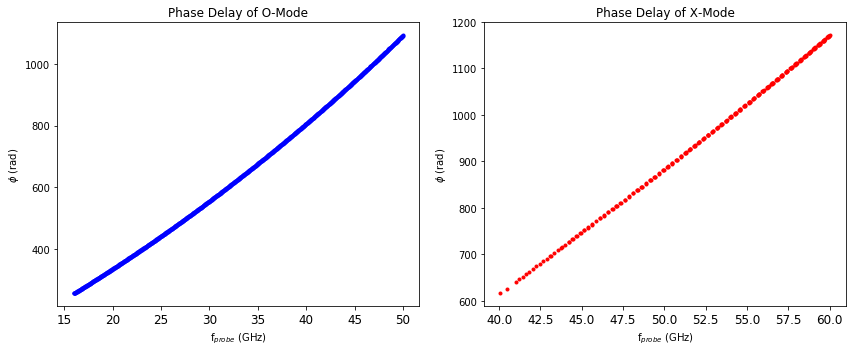

In [166]:
plt.figure(figsize=fig_size)

plt.subplot(1, 2, 1)

plt.plot(fs_O/1e9, phi_O, 'b.-')

plt.title('Phase Delay of O-Mode')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel('$\phi$ (rad)')

plt.subplot(1, 2, 2)

plt.plot(fs_X/1e9, phi_X, 'r.-')

plt.title('Phase Delay of X-Mode')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel('$\phi$ (rad)')

plt.tight_layout()
#plt.savefig('images/phase_delays.png', dpi=200)
plt.show()

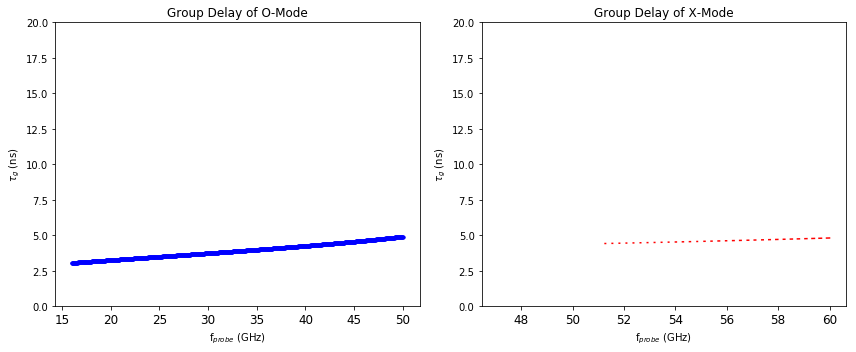

In [167]:
delta_t_O = group_delay(fs_O, phi_O)
delta_t_X = group_delay(fs_X, phi_X)

lim_val = 20e-9
curb = delta_t_O>lim_val
delta_t_O[curb] = lim_val

plt.figure(figsize=fig_size)

plt.subplot(1, 2, 1)

plt.plot(fs_O/1e9, delta_t_O*1e9, 'b.-')

plt.title('Group Delay of O-Mode')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel(r'$\tau_g$ (ns)')

plt.ylim(0, 20)

plt.subplot(1, 2, 2)

plt.plot(fs_X/1e9, delta_t_X*1e9, 'r-')

plt.title('Group Delay of X-Mode')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel(r'$\tau_g$ (ns)')

plt.ylim(0, 20)

plt.tight_layout()
#plt.savefig('images/group_delays.png', dpi=200)
plt.show()

In [20]:
beat_sig = np.cos(phi_O)

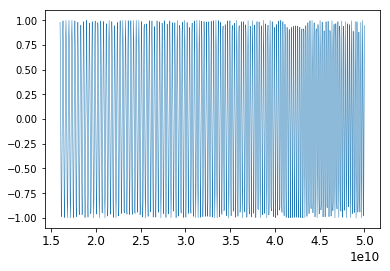

In [25]:
plt.plot(fs_O, beat_sig,lw=0.5)

/home/guimas/anaconda3/envs/ref/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/guimas/anaconda3/envs/ref/lib/python3.6/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


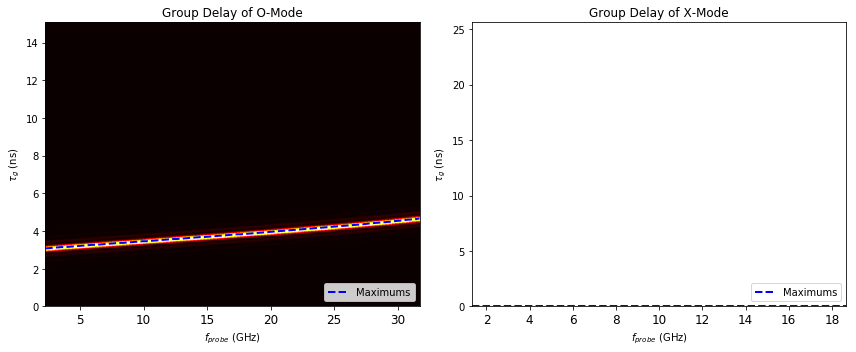

In [168]:
beat_sig_X = beat_signal(fs_X, delta_t_X)

fs, ts, spectrum = spectrogram(beat_sig, fs=f_sampling, nperseg=136, nfft=256, noverlap=128)
beat_max = beat_maximums(fs, spectrum)

fsamp_X, ts_X, spectrum_X = spectrogram(beat_sig_X, fs=f_sampling_X, nperseg=128+64, nfft=2048, noverlap=128)
beat_max_X = beat_maximums(fsamp_X, spectrum_X)

delta_t_noise = beat_max / sweep_rate
fs_noise = ts * sweep_rate

plt.figure(figsize=fig_size)

plt.subplot(1, 2, 1)

plot_beat_spectogram(f_sampling, beat_sig, sweep_rate, title='O-Mode')

plt.subplot(1, 2, 2)

plot_beat_spectogram(f_sampling_X, beat_sig_X, sweep_rate_X, title='X-Mode')

plt.tight_layout()
#plt.savefig('images/spectrogram.png', dpi=200)
plt.show()

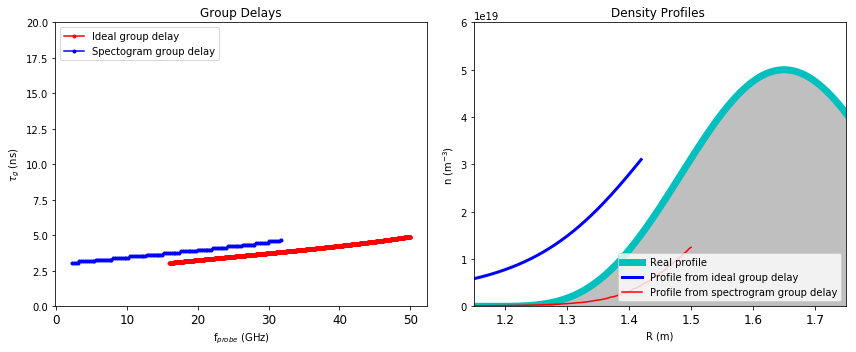

In [169]:
radius_calc, dens_arr_to_calc = abel_inversion(fs_O, delta_t_O, pos_antenna=radius_arr[0]+.015, other_method=False)
radius_calc_other, dens_arr_to_calc_other = abel_inversion(fs_O, delta_t_O, pos_antenna=radius_arr[0], other_method=True)
radius_noise, dens_noise = abel_inversion(fs_noise, delta_t_noise, pos_antenna=radius_arr[0], other_method=True)

plt.figure(figsize=fig_size)

plt.subplot(1, 2, 1)

plt.plot(fs_O*1e-9, delta_t_O*1e9, 'r.-', label='Ideal group delay')
plt.plot(fs_noise*1e-9, delta_t_noise*1e9, 'b.-', label='Spectogram group delay')

plt.title('Group Delays')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel(r'$\tau_g$ (ns)')

plt.ylim(0, 20)

plt.legend(loc='upper left')

plt.subplot(1, 2, 2)

plot_profiles_reconstruction(radius_arr, dens_prof, radius_calc_other, dens_arr_to_calc_other,
                             radius_noise, dens_noise, xlims=(1.15, 1.75), ylims=(0, 6e19), title='')

plt.tight_layout()
#plt.savefig('images/reconstruction.png', dpi=200)
plt.show()

In [170]:
rad, dens = CalcInvPerfO(fs_O, delta_t_O, vacd=0.19, initpts=32)
rad = max(rs) - rad

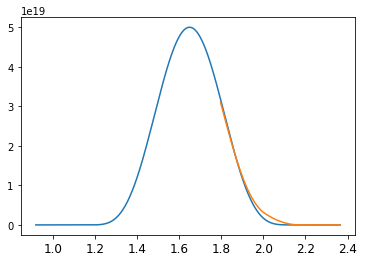

In [171]:
plt.plot(rs, ns)
plt.plot(rad, dens)